# Analyze sessions in batch from Phase 1 of AdaDrive (work in progress)

In [1]:
from mna.utils.rnapp_data_format import read_all_lslpresets, return_metadata_from_name, event_data_from_data
import pickle, os
import pandas as pd
import numpy as np
import seaborn as sns
from IPython.display import display

import matplotlib.pyplot as plt
from mna.sessions.eye_session import process_session_eye
from mna.sessions.eeg_session import process_session_eeg
from mna.sessions.motor_session import process_session_motor
from mna.sessions.ecg_session import process_session_ecg
# 1. Read a RN App, converted pkl file, and create the metadata and data structure

ModuleNotFoundError: No module named 'mne_features'

In [ ]:
import matplotlib
matplotlib.use('Agg')

# Batch convert raw files into pickle

In [2]:
from mna.utils.rnapp_data_format import read_all_files

In [3]:
read_all_files(data_dir='/Volumes/GoogleDrive/My Drive/Research Work/BCIFlow/In-Lab_Recordings/',
               pickle_dir='/Volumes/GoogleDrive/My Drive/Research Work/BCIFlow/Pkl_Recordings/', save_pickle=True)

processing file 08_06_2022_10_38_47-Exp_adadrive-Sbj_09-Ssn_01.dats
processing file 08_07_2022_09_29_24-Exp_adadrive-Sbj_09-Ssn_02.dats
processing file 08_05_2022_13_58_54-Exp_adadrive-Sbj_11-Ssn_1.dats
processing file 08_05_2022_08_53_10-Exp_adadrive-Sbj_07-Ssn_02.dats
processing file 08_05_2022_10_25_29-Exp_adadrive-Sbj_10-Ssn_01.dats
processing file 08_04_2022_11_37_08-Exp_adadrive-Sbj_08-Ssn_02.dats
processing file 08_03_2022_14_22_41-Exp_adadrive-Sbj_08-Ssn_01.dats
Stream-in completed: /Volumes/GoogleDrive/My Drive/Research Work/BCIFlow/In-Lab_Recordings/08_05_2022_13_58_54-Exp_adadrive-Sbj_11-Ssn_1.dats
processing file .DS_Store


Exception: Data invalid, magic sequence not found

# Batch analysis

In [4]:
# read_all_files(data_dir = './../In-Lab Recordings/')
from os import listdir
from os.path import isfile, join

data_dir = "/Volumes/GoogleDrive/My Drive/Research Work/BCIFlow/Pkl_Recordings/"
lsl_dir = "../mna/LSLPresets/"
output_dir = '../output/'
if not os.path.isdir(output_dir): os.makedirs(output_dir)
metadata_jsons = read_all_lslpresets(path_to_jsonfiles=lsl_dir)
onlyfiles = [f for f in listdir(data_dir) if isfile(join(data_dir, f)) and '.pkl' in f]
all_dfs=None
for each_file in onlyfiles:
    input_path = data_dir + each_file

    with open(input_path, 'rb') as handle:
        rns_data = pickle.load(handle)

    ## Add metadata to data

    for key in rns_data.keys():
        rns_data[key].append(return_metadata_from_name(key, metadata_jsons))

    event_df = event_data_from_data(rns_data)
    event_df['trial_damage'] = event_df.damage.diff().fillna(0)
    event_df['trial_duration'] = event_df.trial_end_time - event_df.trial_start_time
    percent_missing = event_df.notnull().sum() / len(event_df)
    summary_statistics = {}
    summary_statistics['voice_success_rate'] = percent_missing['voice_timestamp']
    if 'chunk_timestamp' in percent_missing:
        summary_statistics['chunk_success_rate'] = percent_missing['chunk_timestamp']
    else:
        summary_statistics['chunk_success_rate'] = 0

    # temporary fix for pilot phase where we had some incomplete data
    if 'block_condition' not in event_df:
        event_df['block_condition'] = 'practice'
        event_df.loc[5:,'block_condition'] = 'voice'
    event_df['spoken_difficulty_encoded'] = event_df.spoken_difficulty.replace(to_replace=['easy', 'hard'],
                                                                            value=[1, 2])

    summary_statistics['trial_count'] = (event_df.block_condition!='practice').sum()
    summary_statistics['hard_trials_rate'] = (event_df.spoken_difficulty=='hard').sum()/event_df.spoken_difficulty.notnull().sum()
    
    # ecg
    post_processed_event_df = process_session_ecg(rns_data, event_df,plot_frequency=20,plot_ecg_snippet=40)

    # eye
    post_processed_event_df = process_session_eye(rns_data, post_processed_event_df,detect_blink=True,plot_frequency=20, plot_eye_snippet=40)

    # eeg
    post_processed_event_df, epochs, events, event_dict, info, reject_log, ica = process_session_eeg(rns_data, post_processed_event_df,
                                                                    event_column='spoken_difficulty_encoded', run_autoreject=True, run_ica=True)
    
    # motor
    post_processed_event_df = process_session_motor(rns_data, post_processed_event_df, motor_channel='Unity_MotorInput',
                                                plot_motor_result = True, plot_motor_snippet = 30, plot_frequency = 10)

    
    # save
    post_processed_event_df.to_csv(f"{output_dir}ppid_{post_processed_event_df.iloc[0].ppid}_session_{post_processed_event_df.iloc[0].session}.csv")
    if not type(all_dfs)==pd.core.frame.DataFrame:
        all_dfs = post_processed_event_df
    else:
        all_dfs = pd.concat([all_dfs, post_processed_event_df], ignore_index=True)


Unity_ChunkInfo not found


NameError: name 'process_session_ecg' is not defined

# Save results and generate interactive PivotTable

In [ ]:
from pivottablejs import pivot_ui
all_dfs.to_csv(f"{output_dir}all_results.csv")
pivot_ui(all_dfs, outfile_path=f"{output_dir}all_results.html");

# Misc Plots

In [22]:
# remove practice trials
all_dfs_final = all_dfs.copy()
all_dfs_final = all_dfs_final[all_dfs_final.block_condition!='practice']
all_dfs_final['ppid_session'] = all_dfs_final['ppid'].astype(int).astype(str) + '_' + \
                                            + all_dfs_final['session'].astype(int).astype(str)

all_dfs_final.columns = all_dfs_final.columns.str.replace('.','_')
all_dfs_final.columns = all_dfs_final.columns.str.replace('measures_','')


cols_of_interest = ["bpm", "density", "trial_duration", "trial_damage",
                                     "abs_sum_delta_steer_input", "abs_sum_delta_brake_input",
                                     "NSLR_count_Fixation", "NSLR_count_Saccade"]
experimental_cols = ['spoken_difficulty', 'trial_duration', 'density', 'trial_damage']
eye_cols = ['spoken_difficulty', "NSLR_count_Fixation", "NSLR_count_Saccade",
            'NSLR_mean_duration_Fixation','NSLR_mean_duration_Saccade',
           'NSLR_first_onset_Fixation', 'NSLR_first_onset_Saccade']
ecg_cols = ['spoken_difficulty','density','bpm','sdnn', 'rmssd','pnn50'] # rmssd = parasympathetic
motor_cols = ['spoken_difficulty','density','abs_sum_delta_steer_input','abs_sum_delta_brake_input', 'abs_sum_delta_throttle_input'] 

# nan outliers
for col in cols_of_interest:
    all_dfs_final[col] = all_dfs_final[col].mask(all_dfs_final[col].sub(all_dfs_final[col].mean()).div(all_dfs_final[col].std()).abs().gt(2))
all_dfs_final['abs_sum_delta_brake_input'] = all_dfs_final['abs_sum_delta_brake_input'].mask(all_dfs_final['abs_sum_delta_brake_input']>.1)
all_dfs_final['NSLR_first_onset_Fixation'] = all_dfs_final['NSLR_first_onset_Fixation']-all_dfs_final['trial_start_time']
all_dfs_final['NSLR_first_onset_Saccade'] = all_dfs_final['NSLR_first_onset_Saccade']-all_dfs_final['trial_start_time']

In [23]:
# quality measurse
speech_recognition = pd.DataFrame(all_dfs_final.groupby("ppid_session").apply(lambda x: x['spoken_difficulty'].notnull().mean()))
display('speech_recognition_min',speech_recognition.min().values,
        'speech_recognition_max',speech_recognition.max(),
        'speech_recognition.mean', speech_recognition.mean())
autorejected = pd.DataFrame(all_dfs_final.groupby("ppid_session").apply(lambda x: np.nansum(x['autorejected'])/len(x['autorejected'])))
display('autorejected_trials_min',autorejected.min(),
        'autorejected_trials_max',autorejected.max(),
        'autorejected_trials_mean', autorejected.mean())
bad_beats = pd.DataFrame(all_dfs_final.groupby("ppid_session").apply(lambda x: x['removed_beat_rate']))
display('bad_beats_perc_min',bad_beats.min(),
        'bad_beats_perc_max',bad_beats.max(),
        'bad_beats_perc_mean', bad_beats.mean())


'speech_recognition_min'

array([0.30508475])

'speech_recognition_max'

0    0.592857
dtype: float64

'speech_recognition.mean'

0    0.492968
dtype: float64

'autorejected_trials_min'

0    0.019231
dtype: float64

'autorejected_trials_max'

0    0.164286
dtype: float64

'autorejected_trials_mean'

0    0.066322
dtype: float64

'bad_beats_perc_min'

removed_beat_rate    0.0
dtype: float64

'bad_beats_perc_max'

removed_beat_rate    0.755556
dtype: float64

'bad_beats_perc_mean'

removed_beat_rate    0.240197
dtype: float64

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


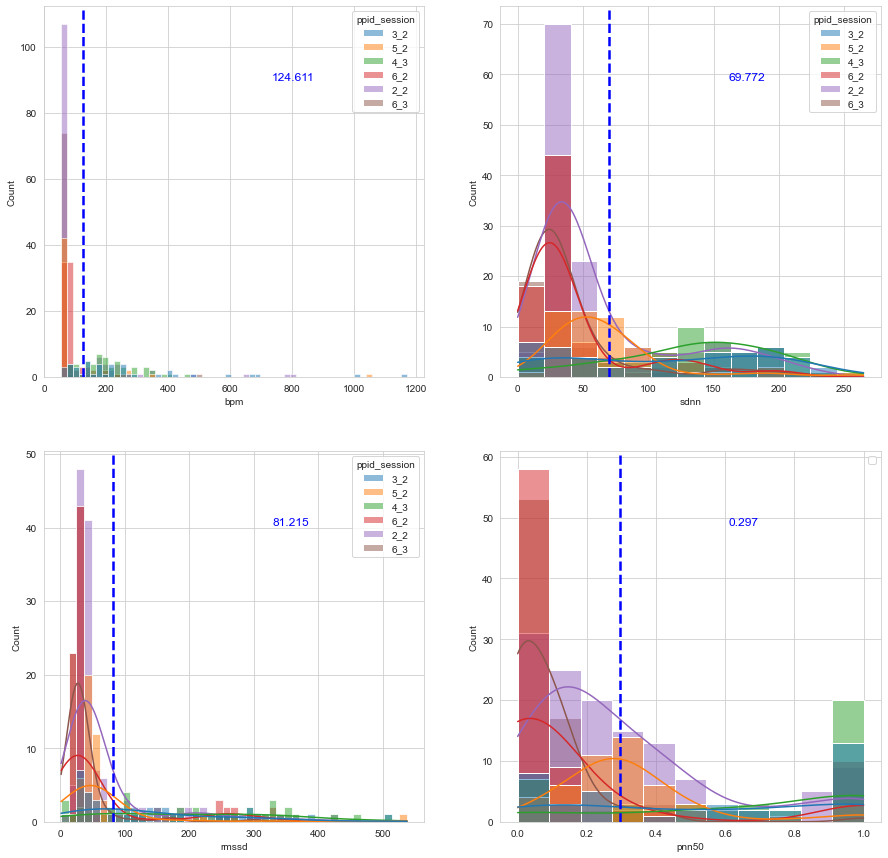

In [24]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15))
sns.histplot(data=all_dfs_final, x="bpm", kde=False, color="skyblue", label="Sepal Length", ax=axs[0, 0], hue='ppid_session')
axs[0, 0].axvline(x=all_dfs_final.bpm.mean(),
            color='blue',
            ls='--', 
            lw=2.5)
axs[0, 0].text(0.6,.8, round(all_dfs_final.bpm.mean(),3), color='blue', fontsize = 12, transform=axs[0, 0].transAxes)


sns.histplot(data=all_dfs_final, x="sdnn", kde=True, color="olive", ax=axs[0, 1], hue='ppid_session')
axs[0, 1].axvline(x=all_dfs_final.sdnn.mean(),
            color='blue',
            ls='--', 
            lw=2.5)
axs[0, 1].text(0.6,.8, round(all_dfs_final.sdnn.mean(),3), color='blue', fontsize = 12, transform=axs[0, 1].transAxes)


sns.histplot(data=all_dfs_final, x="rmssd", kde=True, color="gold", ax=axs[1, 0], hue='ppid_session')
axs[1, 0].axvline(x=all_dfs_final.rmssd.mean(),
            color='blue',
            ls='--', 
            lw=2.5)
axs[1, 0].text(0.6,.8, round(all_dfs_final.rmssd.mean(),3), color='blue', fontsize = 12, transform=axs[1, 0].transAxes)


sns.histplot(data=all_dfs_final, x="pnn50", kde=True, color="teal", ax=axs[1, 1], hue='ppid_session')
axs[1, 1].axvline(x=all_dfs_final.pnn50.mean(),
            color='blue',
            ls='--', 
            lw=2.5)
axs[1, 1].text(0.6,.8, round(all_dfs_final.pnn50.mean(),3), color='blue', fontsize = 12, transform=axs[1, 1].transAxes)


plt.legend() 
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


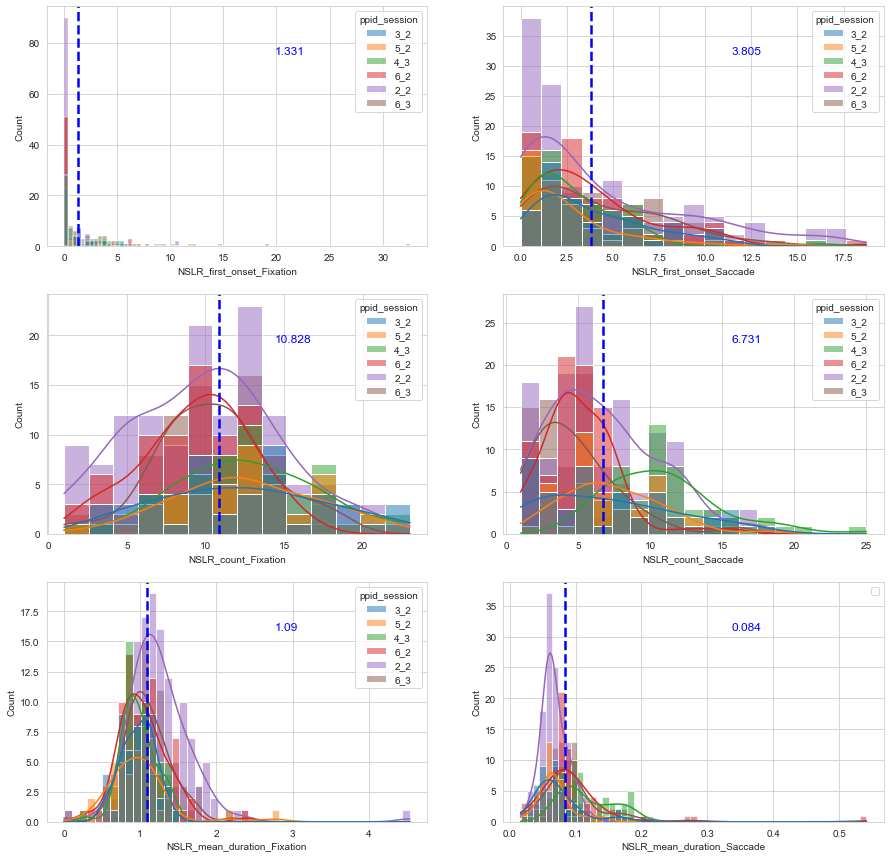

In [25]:
fig, axs = plt.subplots(3, 2, figsize=(15, 15))
sns.histplot(data=all_dfs_final, x="NSLR_first_onset_Fixation", kde=False, color="skyblue", label="Sepal Length", ax=axs[0, 0], hue='ppid_session')
axs[0, 0].axvline(x=all_dfs_final.NSLR_first_onset_Fixation.mean(),
            color='blue',
            ls='--', 
            lw=2.5)
axs[0, 0].text(0.6,.8, round(all_dfs_final.NSLR_first_onset_Fixation.mean(),3), color='blue', fontsize = 12, transform=axs[0, 0].transAxes)


sns.histplot(data=all_dfs_final, x="NSLR_first_onset_Saccade", kde=True, color="olive", ax=axs[0, 1], hue='ppid_session')
axs[0, 1].axvline(x=all_dfs_final.NSLR_first_onset_Saccade.mean(),
            color='blue',
            ls='--', 
            lw=2.5)
axs[0, 1].text(0.6,.8, round(all_dfs_final.NSLR_first_onset_Saccade.mean(),3), color='blue', fontsize = 12, transform=axs[0, 1].transAxes)


sns.histplot(data=all_dfs_final, x="NSLR_count_Fixation", kde=True, color="gold", ax=axs[1, 0], hue='ppid_session')
axs[1, 0].axvline(x=all_dfs_final.NSLR_count_Fixation.mean(),
            color='blue',
            ls='--', 
            lw=2.5)
axs[1, 0].text(0.6,.8, round(all_dfs_final.NSLR_count_Fixation.mean(),3), color='blue', fontsize = 12, transform=axs[1, 0].transAxes)


sns.histplot(data=all_dfs_final, x="NSLR_count_Saccade", kde=True, color="teal", ax=axs[1, 1], hue='ppid_session')
axs[1, 1].axvline(x=all_dfs_final.NSLR_count_Saccade.mean(),
            color='blue',
            ls='--', 
            lw=2.5)
axs[1, 1].text(0.6,.8, round(all_dfs_final.NSLR_count_Saccade.mean(),3), color='blue', fontsize = 12, transform=axs[1, 1].transAxes)


sns.histplot(data=all_dfs_final, x="NSLR_mean_duration_Fixation", kde=True, color="gold", ax=axs[2, 0], hue='ppid_session')
axs[2, 0].axvline(x=all_dfs_final.NSLR_mean_duration_Fixation.mean(),
            color='blue',
            ls='--', 
            lw=2.5)
axs[2, 0].text(0.6,.8, round(all_dfs_final.NSLR_mean_duration_Fixation.mean(),3), color='blue', fontsize = 12, transform=axs[2, 0].transAxes)

sns.histplot(data=all_dfs_final, x="NSLR_mean_duration_Saccade", kde=True, color="teal", ax=axs[2, 1], hue='ppid_session')
axs[2, 1].axvline(x=all_dfs_final.NSLR_mean_duration_Saccade.mean(),
            color='blue',
            ls='--', 
            lw=2.5)
axs[2, 1].text(.6,.8, round(all_dfs_final.NSLR_mean_duration_Saccade.mean(),3), color='blue', fontsize = 12, transform=axs[2, 1].transAxes)

plt.legend() 
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


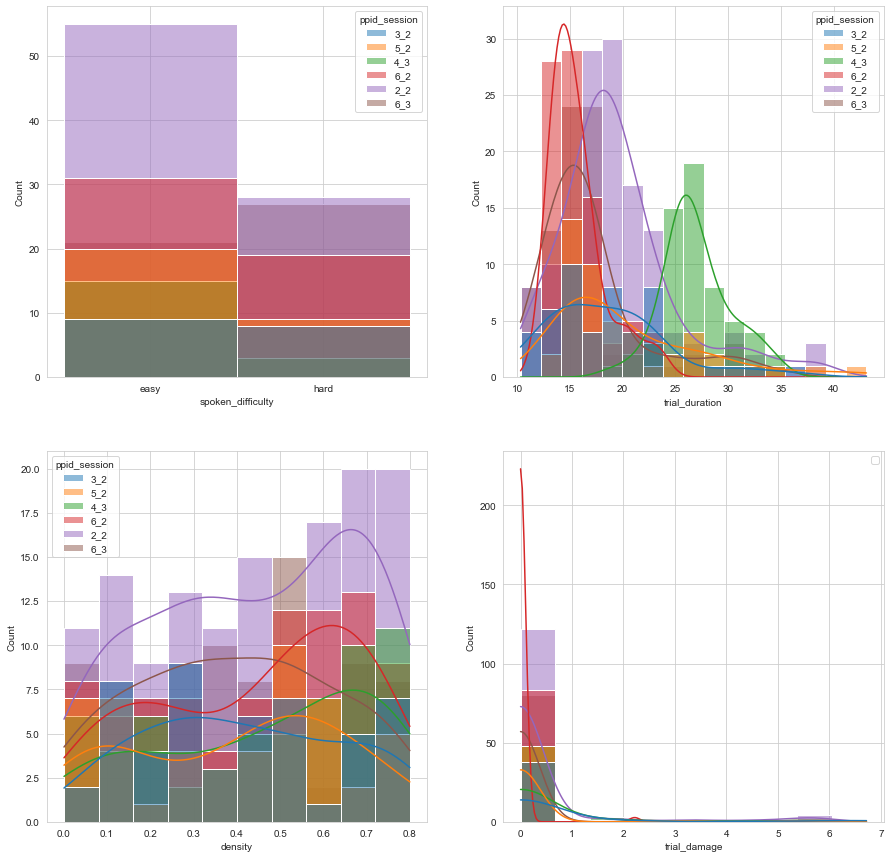

In [26]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15))
sns.histplot(data=all_dfs_final, x="spoken_difficulty", kde=False, color="skyblue", label="Sepal Length", ax=axs[0, 0], hue='ppid_session')
sns.histplot(data=all_dfs_final, x="trial_duration", kde=True, color="olive", ax=axs[0, 1], hue='ppid_session')
sns.histplot(data=all_dfs_final, x="density", kde=True, color="gold", ax=axs[1, 0], hue='ppid_session')
sns.histplot(data=all_dfs_final, x="trial_damage", kde=True, color="teal", ax=axs[1, 1], hue='ppid_session')

plt.legend() 
plt.show()


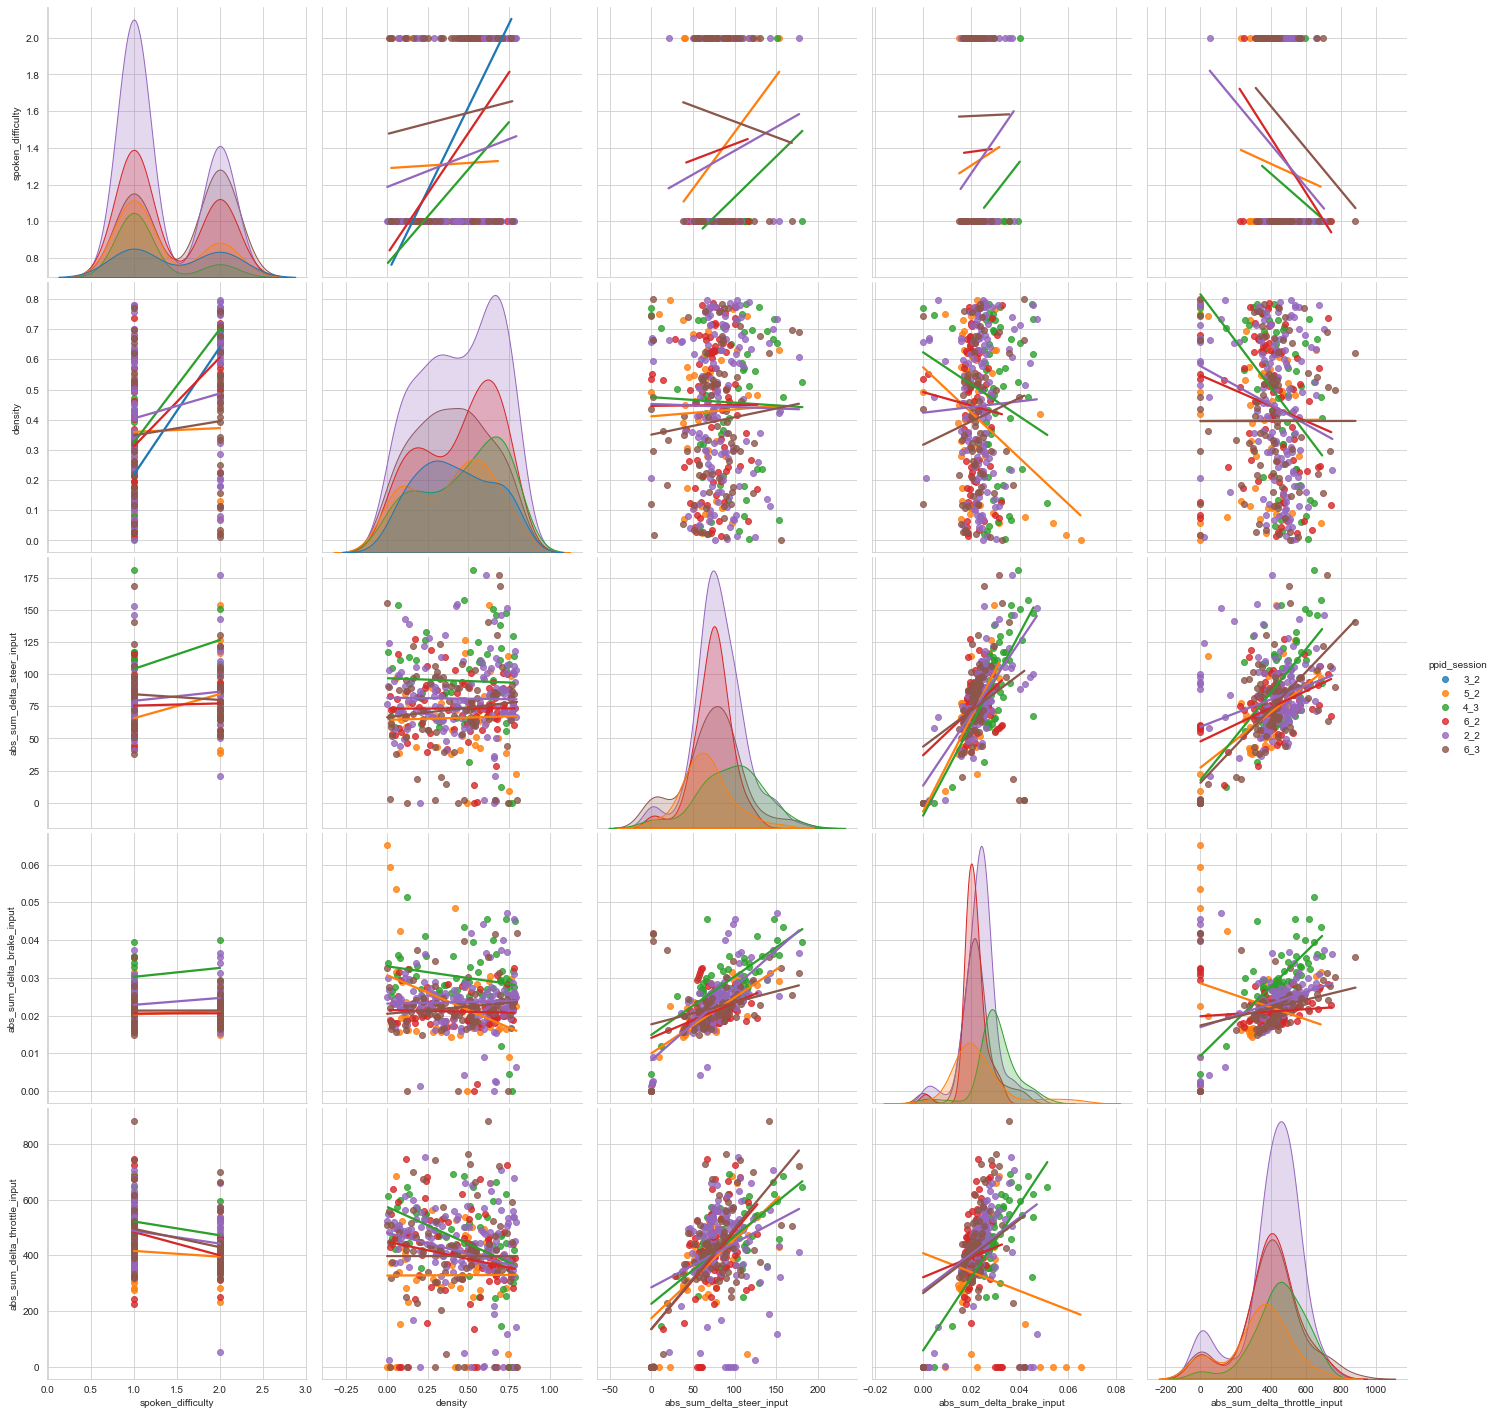

In [27]:
all_dfs_final.loc[all_dfs_final['spoken_difficulty'] == 'easy', 'spoken_difficulty'] = 1
all_dfs_final.loc[all_dfs_final['spoken_difficulty'] == 'hard', 'spoken_difficulty'] = 2
all_dfs_final['spoken_difficulty'] = all_dfs_final['spoken_difficulty'].astype(float)
#g = sns.pairplot(all_dfs_final[experimental_cols+['ppid_session']], kind="reg", vars=experimental_cols,
#                 diag_kind="kde",height=4, hue="ppid_session", plot_kws=dict(ci=None))

# eye cols
saccade_cols = ['spoken_difficulty', 'density',"NSLR_count_Saccade",'NSLR_mean_duration_Saccade',
           'NSLR_first_onset_Saccade']
#g = sns.pairplot(all_dfs_final[saccade_cols+['ppid_session']], kind="reg", vars=saccade_cols,
#                 diag_kind="kde",height=4, hue="ppid_session", plot_kws=dict(ci=None))

#g = sns.pairplot(all_dfs_final[ecg_cols+['ppid_session']], kind="reg", vars=ecg_cols,
#                 diag_kind="kde",height=4, hue="ppid_session", plot_kws=dict(ci=None))

g = sns.pairplot(all_dfs_final[motor_cols+['ppid_session']], kind="reg", vars=motor_cols,
                 diag_kind="kde",height=4, hue="ppid_session", plot_kws=dict(ci=None))

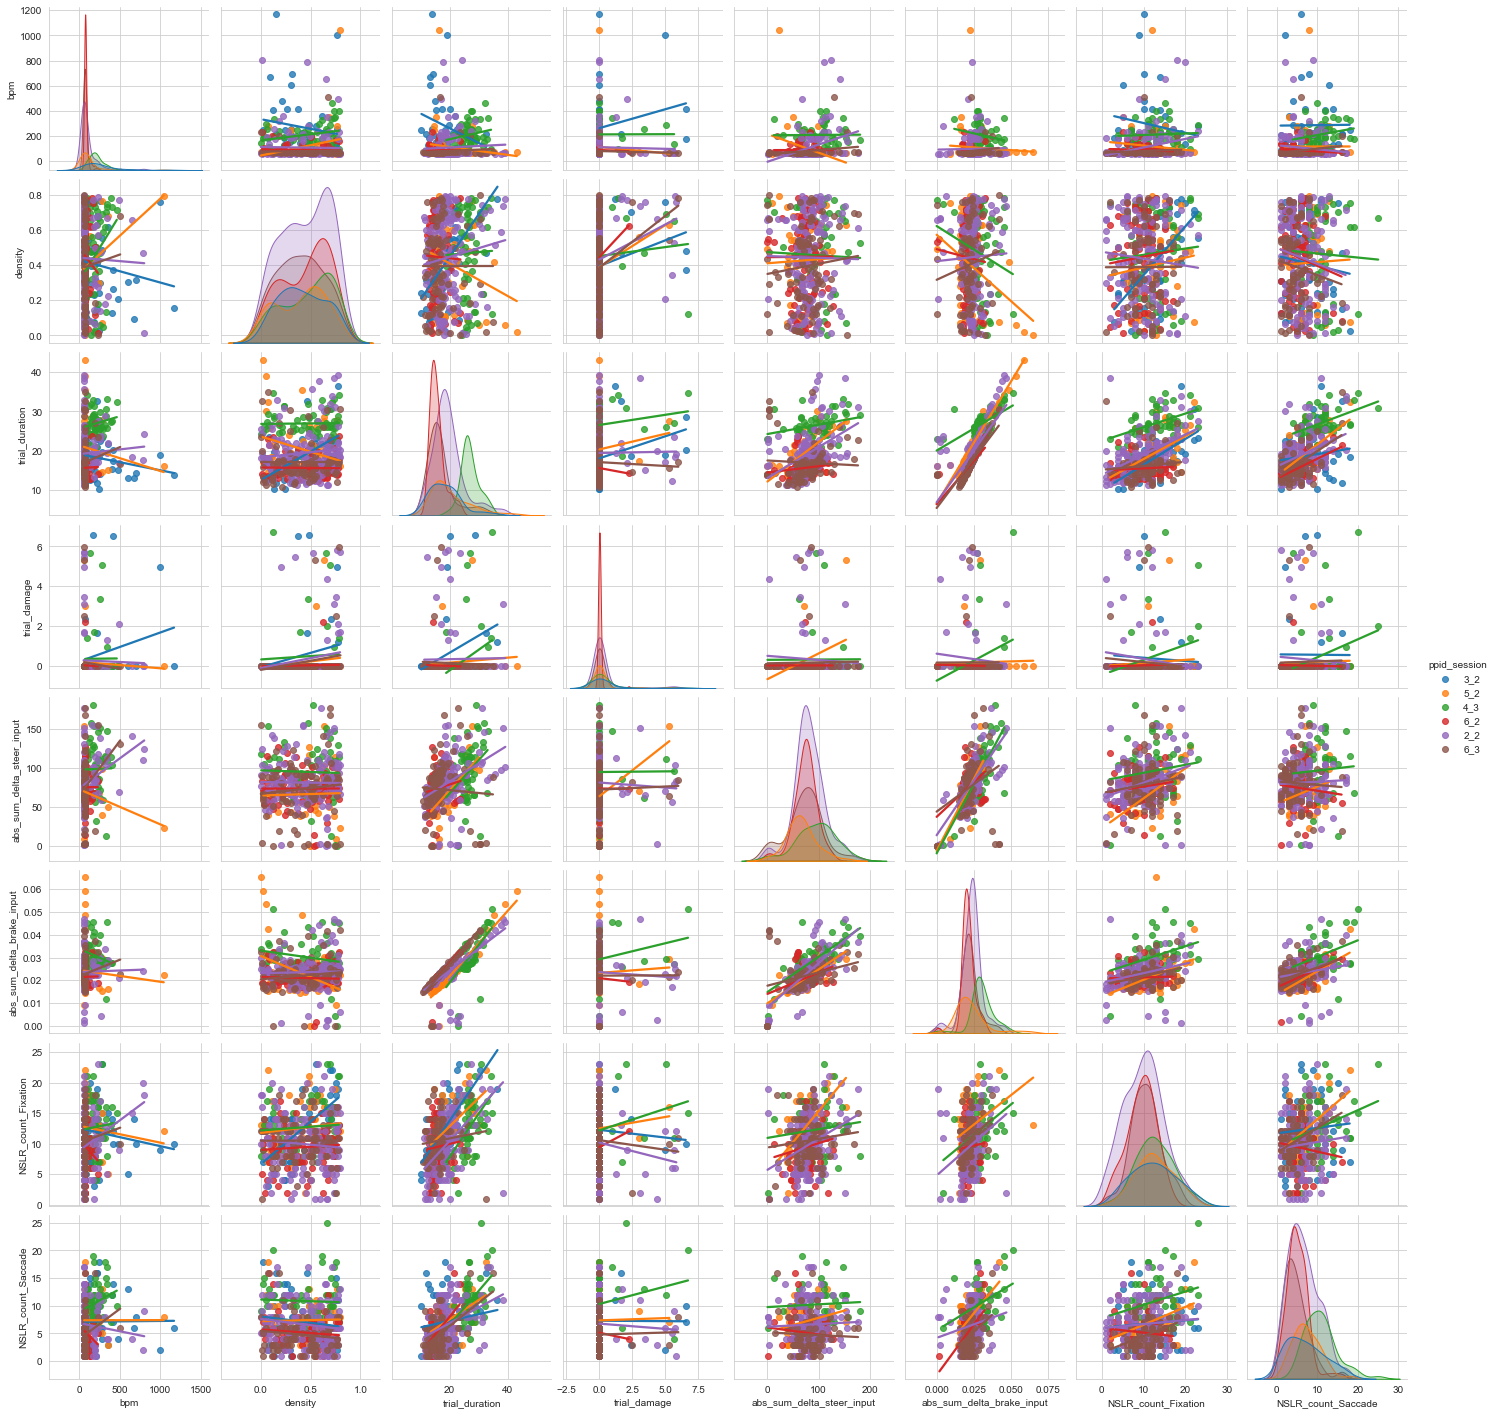

In [28]:
import seaborn as sns
g = sns.pairplot(all_dfs_final, kind="reg", vars=cols_of_interest,
                 diag_kind="kde",height=2.5, hue="ppid_session", plot_kws=dict(ci=None))



In [29]:
all_dfs_final[eye_cols+['ppid_session']].groupby('ppid_session').describe()

spoken_difficulty                                               \
                         count      mean       std  min  25%  50%  75%  max   
ppid_session                                                                  
2_2                       83.0  1.337349  0.475679  1.0  1.0  1.0  2.0  2.0   
3_2                       17.0  1.470588  0.514496  1.0  1.0  1.0  2.0  2.0   
4_3                       18.0  1.166667  0.383482  1.0  1.0  1.0  1.0  2.0   
5_2                       29.0  1.310345  0.470824  1.0  1.0  1.0  2.0  2.0   
6_2                       50.0  1.380000  0.490314  1.0  1.0  1.0  2.0  2.0   
6_3                       48.0  1.562500  0.501328  1.0  1.0  2.0  2.0  2.0   

             NSLR_count_Fixation             ... NSLR_first_onset_Fixation  \
                           count       mean  ...                       75%   
ppid_session                                 ...                             
2_2                        132.0   9.931818  ...                  1.032690   
3_2                         46.0  12.347826  ...                  1.560218   
4_3                         57.0  12.736842  ...                  3.341436   
5_2                         44.0  12.568182  ...                  1.205245   
6_2                         81.0   9.444444  ...                  1.435601   
6_3                         77.0  10.506494  ...                  1.362293   

                        NSLR_first_onset_Saccade                      \
                    max                    count      mean       std   
ppid_session                                                           
2_2           14.787956                    132.0  4.347648  4.527639   
3_2            6.297363                     51.0  3.820324  2.884998   
4_3           12.325783                     58.0  2.859397  2.603268   
5_2           11.874446                     44.0  2.587108  2.895395   
6_2           19.121308                     82.0  3.837152  3.410960   
6_3           32.557569                     73.0  4.263484  3.403111   

                                                                 
                   min       25%       50%       75%        max  
ppid_session                                                     
2_2           0.001241  0.931135  2.266251  7.073613  17.073931  
3_2           0.262880  1.276569  2.813184  5.500166  10.982025  
4_3           0.316842  1.027845  2.118880  3.965141  16.169133  
5_2           0.007086  0.780555  1.475644  3.283021  14.040846  
6_2           0.002236  1.249268  2.949356  5.401182  18.738049  
6_3           0.001800  1.443549  3.533131  6.814372  14.122717  

[6 rows x 56 columns]